In [ ]:
!pip install gymnasium
!pip install -q swig
!pip install -q gymnasium[box2d]
import gymnasium as gym
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  Preparing metadata (setup.py) ... done


### Problem-2: Policy Gradient

#### (a)

In [ ]:
env = gym.make("CartPole-v1")

print('Two Actions (Push cart to the left, Push cart to the right): ', env.action_space)
print('State space comprises of Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity: ', env.observation_space)

print("\nRandom agent to understand reward and states: \n")
state, _ = env.reset()

for i in range(5):

    action = env.action_space.sample()
    next_state, reward, terminated, trucated, _ = env.step(action)

    print(f'state: {state}')
    print(f'action: {action}')
    print(f'next state: {next_state}')
    print(f'reward: {reward}\n')

    state = next_state

    if(terminated or trucated):
        print('terminated or truncated here\n')
        state, _ = env.reset()

Two Actions (Push cart to the left, Push cart to the right):  Discrete(2)
State space comprises of Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Random agent to understand reward and states: 

state: [0.01785163 0.01550603 0.03384456 0.00112172]
action: 1
next state: [ 0.01816175  0.21012667  0.03386699 -0.28069365]
reward: 1.0

state: [ 0.01816175  0.21012667  0.03386699 -0.28069365]
action: 0
next state: [0.02236428 0.01453839 0.02825312 0.02247551]
reward: 1.0

state: [0.02236428 0.01453839 0.02825312 0.02247551]
action: 1
next state: [ 0.02265505  0.20924401  0.02870263 -0.26116106]
reward: 1.0

state: [ 0.02265505  0.20924401  0.02870263 -0.26116106]
action: 1
next state: [ 0.02683993  0.40394473  0.02347941 -0.5446544 ]
reward: 1.0

state: [ 0.02683993  0.40394473  0.02347941 -0.5446544 ]
action: 1
next state: [ 0.034918

In [ ]:
env = gym.make("LunarLander-v2")

print('Four Actions (do nothing, fire left orientation engine, fire main engine, fire right orientation engine): ', env.action_space)
print('State space comprises of coordinates of lander in x&y, velocities in x&y, angle, angular velocity, two booleans (whether each leg is in contact with the ground or not): ', env.observation_space)

print("\nRandom agent to understand reward and states: \n")
state, _ = env.reset()

for i in range(5):

    action = env.action_space.sample()
    next_state, reward, terminated, trucated, _ = env.step(action)

    print(f'state: {state}')
    print(f'action: {action}')
    print(f'next state: {next_state}')
    print(f'reward: {reward}\n')

    state = next_state

    if(terminated or trucated):
        print('terminated or truncated here\n')
        state, _ = env.reset()

Four Actions (do nothing, fire left orientation engine, fire main engine, fire right orientation engine):  Discrete(4)
State space comprises of coordinates of lander in x&y, velocities in x&y, angle, angular velocity, two booleans (whether each leg is in contact with the ground or not):  Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

Random agent to understand reward and states: 

state: [ 3.0784606e-04  1.4192815e+00  3.1153053e-02  3.7162289e-01
 -3.4979358e-04 -7.0566935e-03  0.0000000e+00  0.0000000e+00]
action: 2
next state: [ 6.9036486e-04  1.4280188e+00  3.8245775e-02  3.8832608e-01
 -3.3865991e-04  2.2329080e-04  0.0000000e+00  0.0000000e+00]
reward: -2.900482535647046

state: [ 6.9036486e-04  1.4280188e+00  3.8245775e-02  3.8832608e-01
 -3.3865991e-04  2.2329080e-04  0.0000000e+00  0.0000000e+00]
action: 3
next state: [ 1.1642457e-03  1.4361553

#### (b)

In [21]:
class policy_network(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(policy_network, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=-1)
        return x

In [22]:
class policy_gradient():

    def __init__(self, env, reward_to_go=True, advantage_normalization=True, batch_size=200, num_epochs=600, lr=1e-4, gamma=0.99):
        self.env = env
        state, _ = self.env.reset()
        self.n_observation = len(state)
        self.n_action = self.env.action_space.n

        self.policy_net = policy_network(self.n_observation, self.n_action)
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), self.lr)

        self.batch_size = batch_size
        self.time_steps = 200
        self.gamma = gamma
        self.reward_to_go = reward_to_go
        self.advantage_normalization = advantage_normalization

        if torch.cuda.is_available():
            self.num_epochs = num_epochs
        else:
            self.num_epochs = min(num_epochs, 600)

        return

    def train(self):

        transition = namedtuple('transition', ('state', 'action', 'reward'))

        performance_rewards = []

        for n in range(self.num_epochs):

            samples = []
            self.policy_net.eval()

            for i in range(self.batch_size):

                episode = []

                state, _ = self.env.reset()
                state = torch.tensor(state, dtype=torch.float32, device=device)

                # R = []
                # policy = []

                while True:
                    action_prob = self.policy_net(state)
                    action = torch.argmax(action_prob).item()

                    next_state, reward, terminated, trucated, _ = self.env.step(action)
                    episode.append(transition(state, action, reward))

                    if terminated or trucated:
                        break

                    state = torch.tensor(next_state, dtype=torch.float32, device=device)

                samples.append(episode)

            samples = [transition(*zip(*samples[i])) for i in range(self.batch_size)]

            episode_rewards = [torch.tensor(s.reward) for s in samples]

            G = []

            for rewards in episode_rewards:
                discounts = torch.tensor([self.gamma ** k for k in range(rewards.size(0))], dtype=torch.float32, device=device)
                R = discounts*rewards
                if self.reward_to_go:
                    R = torch.tensor([torch.sum(R[k:]).item() for k in range(rewards.size(0))], dtype=torch.float32, device=device)
                else:
                    R = torch.tensor([torch.sum(R).item() for k in range(rewards.size(0))], dtype=torch.float32, device=device)
                G.append(R)

            baseline = torch.mean(torch.tensor([R[0] for R in G]))
            A = [a-baseline for a in G]

            # Advantage Normalization
            if self.advantage_normalization:
                A = [(a-torch.mean(a))/(torch.std(a) + 1e-6) for a in A]

            self.policy_net.train()
            loss = 0
            for i in range(self.batch_size):
                states = torch.cat(samples[i].state, dim=0).reshape(-1, self.n_observation)
                policy = self.policy_net(states)
                policy = torch.max(policy, dim=1).values
                policy = torch.log(policy)
                loss += -1*torch.sum(policy * A[i])
            loss = loss/self.batch_size
            if n%10==0 : print(f'Loss at epoch {n} is {loss}')
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.policy_net.eval()

            if n%10 == 0:
                test_rewards = 0.0

                for i in range(10):
                    state, _ = self.env.reset()
                    state = torch.tensor(state, dtype=torch.float32, device=device)
                    r = 0.0
                    while True:
                        action_prob = self.policy_net(state)
                        action = torch.argmax(action_prob).item()
                        next_state, reward, terminated, trucated, _ = self.env.step(action)
                        r += reward
                        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
                        state = next_state

                        if terminated or trucated:
                            break
                    test_rewards += r

                performance_rewards.append(test_rewards/10)

        return performance_rewards

In [ ]:
env = gym.make("CartPole-v1")
model = policy_gradient(env)
perfomance_rewards_with = model.train()

Loss at epoch 0 is 0.02318454533815384
Loss at epoch 10 is -0.1004771813750267
Loss at epoch 20 is -0.16504453122615814
Loss at epoch 30 is -0.23549224436283112
Loss at epoch 40 is -0.3050036132335663
Loss at epoch 50 is -0.3743335008621216
Loss at epoch 60 is -0.4544318914413452
Loss at epoch 70 is -0.5388767719268799
Loss at epoch 80 is -0.6128851175308228
Loss at epoch 90 is -0.6887718439102173
Loss at epoch 100 is -0.7785415053367615
Loss at epoch 110 is -0.8733673691749573
Loss at epoch 120 is -0.9600438475608826
Loss at epoch 130 is -1.0468342304229736
Loss at epoch 140 is -1.1371232271194458
Loss at epoch 150 is -1.2310893535614014
Loss at epoch 160 is -1.3080856800079346
Loss at epoch 170 is -1.3945956230163574
Loss at epoch 180 is -1.4788293838500977
Loss at epoch 190 is -1.5503897666931152
Loss at epoch 200 is -1.612158179283142
Loss at epoch 210 is -1.6805440187454224
Loss at epoch 220 is -1.7466620206832886
Loss at epoch 230 is -1.781779170036316
Loss at epoch 240 is -1.826

In [ ]:
env = gym.make("CartPole-v1")
model = policy_gradient(env, advantage_normalization=False, reward_to_go=False)
perfomance_rewards_without = model.train()

Loss at epoch 0 is 0.3395848870277405
Loss at epoch 10 is 0.25106075406074524
Loss at epoch 20 is 0.230195090174675
Loss at epoch 30 is 0.20619884133338928
Loss at epoch 40 is 0.14168167114257812
Loss at epoch 50 is 0.12470945715904236
Loss at epoch 60 is 0.09605436027050018
Loss at epoch 70 is 0.09436989575624466
Loss at epoch 80 is 0.07462368905544281
Loss at epoch 90 is 0.05881160870194435
Loss at epoch 100 is 0.050658807158470154
Loss at epoch 110 is 0.05005601420998573
Loss at epoch 120 is 0.0377039797604084
Loss at epoch 130 is 0.028374772518873215
Loss at epoch 140 is 0.02662910893559456
Loss at epoch 150 is 0.01974531076848507
Loss at epoch 160 is 0.01297494862228632
Loss at epoch 170 is 0.010220766998827457
Loss at epoch 180 is 0.006691493559628725
Loss at epoch 190 is 0.002566443057730794
Loss at epoch 200 is 0.0023942345287650824
Loss at epoch 210 is -0.004031397867947817
Loss at epoch 220 is -0.007117611356079578
Loss at epoch 230 is -0.01043920498341322
Loss at epoch 240 i

[12.9, 9.9, 9.3, 9.5, 9.4, 9.3, 9.4, 9.2, 9.4, 9.6, 9.9, 9.4, 9.4, 9.6, 9.3, 9.8, 9.6, 9.5, 9.2, 10.1, 9.6, 9.1, 9.9, 9.0, 9.9, 9.2, 9.1, 9.1, 9.7, 9.3, 9.5, 9.5, 9.2, 9.0, 9.2, 9.6, 9.1, 9.3, 9.1, 9.3, 9.5, 10.0, 9.8, 9.8, 9.6, 9.3, 10.0, 9.5, 9.5, 10.0, 10.5, 9.9, 8.9, 9.4, 9.7, 9.2, 9.4, 9.8, 10.4, 9.9]
[9.5, 9.3, 9.5, 9.4, 9.6, 9.4, 9.2, 9.5, 9.5, 9.5, 9.5, 9.4, 9.6, 9.5, 9.2, 9.5, 9.5, 9.3, 9.5, 9.6, 9.7, 9.3, 9.7, 9.0, 9.1, 9.1, 9.3, 9.6, 9.7, 9.5, 9.7, 9.8, 9.8, 9.7, 9.9, 10.2, 9.9, 10.0, 9.8, 9.9, 9.6, 10.1, 10.0, 10.0, 10.0, 10.1, 9.8, 10.0, 10.0, 9.8, 9.9, 10.2, 10.0, 9.8, 9.9, 10.1, 9.8, 9.7, 9.7, 10.1]


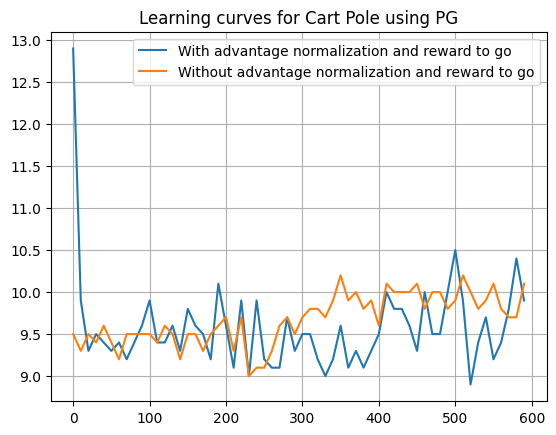

In [ ]:
X = 10*torch.arange(0, len(perfomance_rewards_with))
print((perfomance_rewards_with))
print((perfomance_rewards_without))
plt.plot(X, perfomance_rewards_with, label='With advantage normalization and reward to go')
plt.plot(X, perfomance_rewards_without, label='Without advantage normalization and reward to go')
plt.title("Learning curves for Cart Pole using PG")
plt.grid()
plt.legend()
plt.show()

In [16]:
env = gym.make("LunarLander-v2")
model = policy_gradient(env, num_epochs=120)
performance_rewards_with = model.train()

Loss at epoch 0 is -2.3844006061553955
Loss at epoch 10 is -3.636601209640503
Loss at epoch 20 is -4.943644046783447
Loss at epoch 30 is -6.474636077880859
Loss at epoch 40 is -9.211199760437012
Loss at epoch 50 is -9.8435640335083
Loss at epoch 60 is -11.934284210205078
Loss at epoch 70 is -12.87346076965332
Loss at epoch 80 is -14.468002319335938
Loss at epoch 90 is -16.030961990356445
Loss at epoch 100 is -17.174047470092773
Loss at epoch 110 is -19.64196014404297


In [26]:
env = gym.make("LunarLander-v2")
model = policy_gradient(env, advantage_normalization=False, reward_to_go=False, num_epochs=120)
performance_rewards_without = model.train()

Loss at epoch 0 is -573.5156860351562
Loss at epoch 10 is -142.7722930908203
Loss at epoch 20 is 199.11122131347656
Loss at epoch 30 is 91.91930389404297
Loss at epoch 40 is 103.6613540649414
Loss at epoch 50 is 27.797014236450195
Loss at epoch 60 is 33.4084358215332
Loss at epoch 70 is 41.75596237182617
Loss at epoch 80 is 62.08365249633789
Loss at epoch 90 is 85.02494812011719
Loss at epoch 100 is 10.422048568725586
Loss at epoch 110 is 25.47494888305664


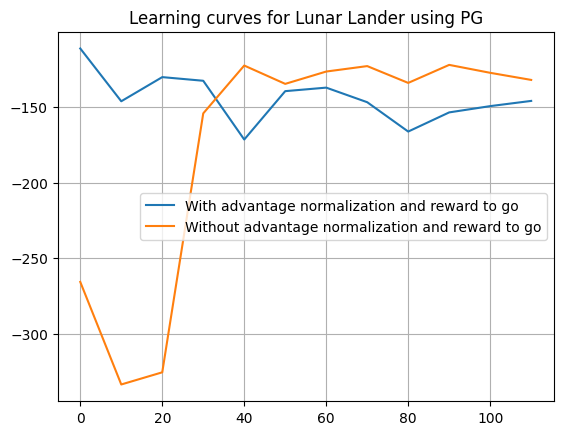

In [31]:
X = 10*torch.arange(0, len(performance_rewards_with))
plt.plot(X, performance_rewards_with, label='With advantage normalization and reward to go')
plt.plot(X, performance_rewards_without, label='Without advantage normalization and reward to go')
plt.title("Learning curves for Lunar Lander using PG")
plt.grid()
plt.legend()
plt.show()

#### (c)

Loss at epoch 0 is 0.174689382314682
Loss at epoch 10 is -0.07249052822589874
Loss at epoch 20 is -0.17390675842761993
Loss at epoch 30 is -0.2514733672142029
Loss at epoch 40 is -0.33186838030815125
Loss at epoch 50 is -0.41194409132003784
Loss at epoch 60 is -0.4944691061973572
Loss at epoch 70 is -0.6123239994049072
Loss at epoch 80 is -0.644072413444519
Loss at epoch 90 is -0.7308706045150757
Loss at epoch 100 is -0.805801272392273
Loss at epoch 110 is -0.8473548889160156
Loss at epoch 0 is 0.3593018651008606
Loss at epoch 10 is 0.00021825730800628662
Loss at epoch 20 is -0.31838929653167725
Loss at epoch 30 is -0.4212423264980316
Loss at epoch 40 is -0.4923895001411438
Loss at epoch 50 is -0.6043603420257568
Loss at epoch 60 is -0.7075494527816772
Loss at epoch 70 is -0.7892112731933594
Loss at epoch 80 is -0.8257313966751099
Loss at epoch 90 is -0.9958741068840027
Loss at epoch 100 is -1.0931147336959839
Loss at epoch 110 is -1.1294251680374146
Loss at epoch 0 is -0.0360796488821

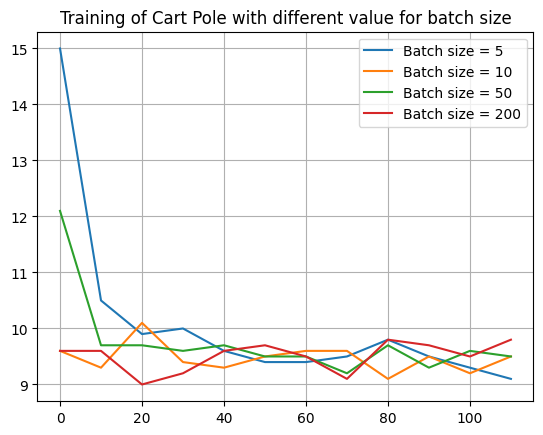

In [34]:
batch_sizes = [5, 10, 50, 200]

plt.title(f"Training of Cart Pole with different value for batch size")

for batch_size in batch_sizes:
    env = gym.make("CartPole-v1")
    model = policy_gradient(env, num_epochs=120, batch_size=batch_size)
    y = model.train()
    x = torch.arange(0 , model.num_epochs, 10)
    plt.plot(x , y , label = f"Batch size = {batch_size}")

plt.grid()
plt.legend()
plt.show()